이적료가 평균 이상인 선수 비율: 30.60%


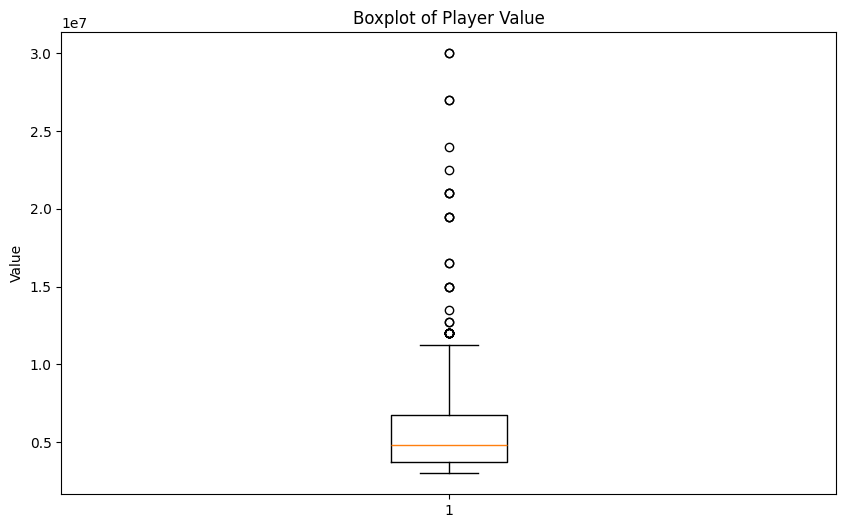

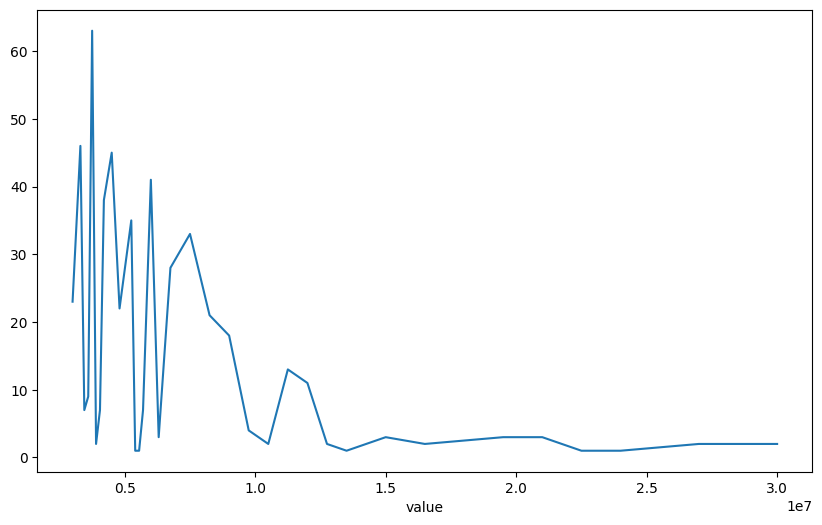

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47161 (\

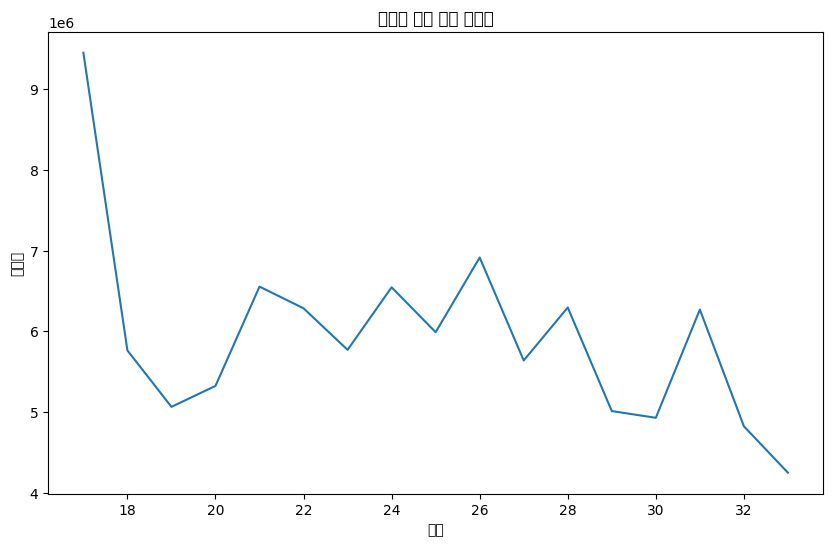

In [ ]:
# transfermarkt 사이트에서 이적료가 높은 선수들의 성과 분석 및 이적료에 미치는 중요 변수 분석
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# 헤더 정보를 넣어주지 않으면 403 에러가 발생할 수 있다.
headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36'}

# 파싱 편의를 위해 사용자 정의 함수 만들어 놓기
def parsingSite(url):
    response=requests.get(url, headers=headers)
    response.status_code
    time.sleep(1)
    # BeautifulSoup으로 웹페이지 분석 준비하기
    psdSite=BeautifulSoup(response.text, 'html.parser')
    return psdSite

# 필요한 정보를 담을 리스트 생성
rank=[] # 순위
player=[] # 선수정보
name=[] # 이름
position=[] # 포지션
age=[] # 나이
country=[] # 국적
club=[] # 소속팀
value=[] # 이적료
matchNum=[] # 경기수 
goal=[] # 골
assist=[] # 어시스트
yellowCard=[] # 옐로카드
redCard=[] # 레드카드
subIn=[] # 교체투입
subOut=[] # 교체아웃
player_list=[] # 선수 정보를 담을 리스트

# 20페이지(500명) 크롤링해보기
for i in range(1, 21):
    # 나중에 한국사이트가 아닌 외국사이트로 바꿔야할 수도 있음 .co.kr -> .com 한국사이트는 한글과 영어가 혼합되어있는 경우가 많아서 외국사이트로 변경경
    url1=f'https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1&page={i}'
    site1=parsingSite(url1)
    
    # 선수 정보가 담긴 태그와 클래스 찾기
    player_info = site1.find_all('tr', class_=['odd', 'even'])
    #print(player_info)
    #print(len(player_info))

    # 가져온 정보 중에서 필요한 정보만 추출하기
    for info in player_info:
        player = info.find_all('td')
        rank = player[0].text
        name = player[3].text
        position = player[4].text
        age = player[5].text
        country = player[6].img['alt']
        club = player[7].img['alt']
        value = player[8].text.strip() # value=value[1:-1] 아예 숫자만 가져오기
        matchNum = player[9].text
        goal = player[10].text
        assist = player[12].text
        yellowCard = player[13].text
        redCard = player[15].text
        subIn = player[16].text
        subOut = player[17].text

        player_list.append([rank, name, position, age, country, club, value, matchNum, goal, assist, yellowCard, redCard, subIn, subOut])
    
    time.sleep(1)
#print(player_list)
# 추출한 정보를 csv 파일로 저장하기
df=pd.DataFrame(player_list, columns=['rank', 'name', 'position', 'age', 'country', 'club', 'value', 'matchNum', 'goal', 'assist', 'yellowCard', 'redCard', 'subIn', 'subOut'])
#df.to_csv('player_info.csv', index=False)
#print(df.head())

# 결측치 처리, 결측치는 없지만 혹시 모르니 해놓기
df.fillna(0, inplace=True)

# 데이터 정제(타입변경 및 이적료 유로->원화환산 ex)30000000.0 ->3000억원)
df['value'] = df['value'].str.replace('€', '').str.replace('.00m', '000000').str.replace('.00k', '000').astype(float)*(0.15)
df['age'] = df['age'].astype(int)
df['matchNum'] = df['matchNum'].astype(int)
df['goal'] = df['goal'].astype(int)
df['assist'] = df['assist'].astype(int)
df['yellowCard'] = df['yellowCard'].astype(int)
df['redCard'] = df['redCard'].astype(int)
df['subIn'] = df['subIn'].astype(int)
df['subOut'] = df['subOut'].astype(int)

# 경기당 득점, 어시스트, 카드 수 등 파생 변수 생성
df['goalPerMatch'] = df['goal']/df['matchNum']
df['assistPerMatch'] = df['assist']/df['matchNum']
df['yellowCardPerMatch'] = df['yellowCard']/df['matchNum']
df['redCardPerMatch'] = df['redCard']/df['matchNum']

#print(df.head())

#기초 통계 분석
#print(df.describe())

#1. 이적료에 대해서만 기초 통계 분석
#2. IQR=3000000이므로 Q3로부터 1.5IQR을 초과하는 이상치는 존재
#3. 그러나, 이적료 순위별로 가져왔기 때문에 극단적인 이상값은 없으으며, 이적료 특성 상 이상치라고 보기 어려움 
pd.options.display.float_format = '{:.3f}'.format
df['value'].describe()

mean_ = df['value'].mean()
# 이적료가 평균 이상인 선수 수
over_mean = len(df[df['value']>mean_])
# 전체 선수 수
total = len(df['value'])
# 평균을 넘는 선수의 비율 : 30.60%
print(f'이적료가 평균 이상인 선수 비율: {over_mean/total*100:.2f}%')

# boxplot을 통한 축구선수 이적료 분포 확인
plt.figure(figsize=(10, 6))
plt.boxplot(df['value'])
plt.title('Boxplot of Player Value')
plt.ylabel('Value')
plt.show()

# 이적료 구간별 선수들의 분포 확인
plt.figure(figsize=(8, 6))
df.groupby('value')['name'].count().plot(kind='bar')
plt.ylabel('Number of Players')
plt.show() 

# 연령별 이적료 데이터
age_market_value = df.groupby('age')['value'].mean()
plt.figure(figsize=(10, 6))
age_market_value.plot()
plt.title('Mean Market Value by Age')
plt.xlabel('Age') 
plt.ylabel('Value')
plt.show()